In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from scipy.stats import ortho_group

from sklearn import decomposition
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
from PIL import Image , ImageFilter
from tqdm import tqdm

In [ ]:
class RealNVPBlock(nn.Module):

    def __init__(self, input_size:int, hidden_size:int,
                       orthogonal_transform:bool = True):
        super().__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.orthogonal_transform = orthogonal_transform

        # For splitting the
        if self.input_size%2 != 0:
            self.i = int(self.input_size//2 + 1)
            self.j = int(self.input_size//2)
        else:
            self.i = int(self.input_size/2)
            self.j = int(self.input_size/2)

        # Construct the sub networks.
        self.s = self.construct_subnetwork(self.i, self.j)
        self.t = self.construct_subnetwork(self.i, self.j)

        # Perfrom the orthogonal transform.
        if orthogonal_transform:
            self.O = nn.Parameter(
                torch.from_numpy(ortho_group.rvs(dim = self.input_size)).float(),
                requires_grad = False)

    def get_subnetworks(self):
        return self.s, self.t

    def get_orthogonal_matrix(self):
        return self.O

    def construct_subnetwork(self, in_dim, out_dim):
        network = [('Fc1', nn.Linear(in_dim, self.hidden_size)),
                   ('relu1', nn.ReLU()),
                   ('Fc2', nn.Linear(self.hidden_size, self.hidden_size)),
                   ('relu2', nn.ReLU()),
                   ('Fc3', nn.Linear(self.hidden_size, out_dim)),
                   ('tah', nn.Tanh())]
        return nn.Sequential(OrderedDict(network))

    def encoder(self, x):
        """Performs the forward through the block."""

        # Perform the pass through the block.
        x1, x2 = x[:,:self.i], x[:, self.i:]
        y1  = x1
        s_f = self.s(x1)
        y2  = torch.mul(x2, torch.exp(s_f)) + self.t(x1)
        y   = torch.concat((y1, y2), axis = 1)

        if self.orthogonal_transform:
            y = torch.matmul(y, self.O)

        # Finally, compute the determinant for the transformation.
        det_J = torch.sum(s_f, axis = -1)

        return y, det_J

    def decoder(self, y):
        """Performs the reverse or inverse pass through the block."""

        if self.orthogonal_transform:
            y = torch.matmul(y, self.O.T)

        # Perform the pass through the block.
        y1, y2 = y[:,:self.i], y[:, self.i:]
        x1  = y1
        s_f = self.s(y1)
        x2  = (y2 - self.t(y1)) * torch.exp(-1 * s_f)

        # Finally, compute the determinant for the transformation.
        det_J = torch.sum(s_f, 1)

        return torch.concat((x1, x2), axis = 1), det_J


    def forward(self, x, reverse:bool = False):

        if reverse:
            return self.decoder(x)
        else:
            return self.encoder(x)


class INN(nn.Module):

    def __init__(self, input_size:int, hidden_size:int, n_blocks:int):
        super().__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks

        self.network = []
        for _ in range(self.n_blocks - 1):
            self.network.append(RealNVPBlock(self.input_size, self.hidden_size,
                                             orthogonal_transform = True))

        # Add the last block without final permutation
        self.network.append(RealNVPBlock(self.input_size, self.hidden_size,
                                         orthogonal_transform = False))
        self.network = nn.ModuleList(self.network)

    def get_network(self) -> list:
        return self.network

    def forward(self, x, reverse:bool = False):

        network_idx = list(range(len(self.network)))
        # Revert the network for the backward pass.
        if reverse:
            network_idx = network_idx[::-1]

        det_Js = []
        for i in network_idx:
            x, det_J = self.network[i](x, reverse = reverse)
            #print(det_J)
            det_Js.append(det_J)

        return x, det_Js

    def sample(self, num_samples:int):
        z = torch.randn((num_samples, self.input_size))
        return self.forward(z, reverse = True)

In [ ]:
class conditionalRealNVPBlock(nn.Module):

    def __init__(self, input_size:int, conditional_size:int, hidden_size:int,
                       orthogonal_transform:bool = True):
        super().__init__()
        self.input_size  = input_size
        self.conditional_size = conditional_size
        self.hidden_size = hidden_size
        self.orthogonal_transform = orthogonal_transform

        # For splitting the
        if self.input_size%2 != 0:
            self.i = int(self.input_size//2 + 1)
            self.j = int(self.input_size//2)
        else:
            self.i = int(self.input_size/2)
            self.j = int(self.input_size/2)

        # Construct the sub networks.
        self.s = self.construct_subnetwork(self.i + self.conditional_size, self.j)
        self.t = self.construct_subnetwork(self.i + self.conditional_size, self.j)

        # Perfrom the orthogonal transform.
        if orthogonal_transform:
            self.O = nn.Parameter(
                torch.from_numpy(ortho_group.rvs(dim = self.input_size)).float(),
                requires_grad = False)

    def get_subnetworks(self):
        return self.s, self.t

    def get_orthogonal_matrix(self):
        return self.O

    def construct_subnetwork(self, in_dim, out_dim):
        network = [('Fc1', nn.Linear(in_dim, self.hidden_size)),
                   ('relu1', nn.ReLU()),
                   ('Fc2', nn.Linear(self.hidden_size, self.hidden_size)),
                   ('relu2', nn.ReLU()),
                   ('Fc3', nn.Linear(self.hidden_size, out_dim)),
                   ('tah', nn.Tanh())]
        return nn.Sequential(OrderedDict(network))

    def encoder(self, x, condition):
        """Performs the forward through the block."""

        # Perform the pass through the block.
        x1, x2 = x[:,:self.i], x[:, self.i:]
        y1  = x1
        x1_cond = torch.concat((x1, condition), axis = 1)
        s_f = self.s(x1_cond)
        y2  = torch.mul(x2, torch.exp(s_f)) + self.t(x1_cond)
        y   = torch.concat((y1, y2), axis = 1)

        if self.orthogonal_transform:
            y = torch.matmul(y, self.O)

        # Finally, compute the determinant for the transformation.
        det_J = torch.sum(s_f, axis = -1)

        return y, det_J

    def decoder(self, y, condition):
        """Performs the reverse or inverse pass through the block."""

        if self.orthogonal_transform:
            y = torch.matmul(y, self.O.T)

        # Perform the pass through the block.
        y1, y2 = y[:,:self.i], y[:, self.i:]
        x1  = y1
        y1_cond  = torch.concat((y1, condition), axis = 1)
        s_f = self.s(y1_cond)
        x2  = (y2 - self.t(y1_cond)) * torch.exp(-1 * s_f)

        # Finally, compute the determinant for the transformation.
        det_J = torch.sum(s_f, 1)

        return torch.concat((x1, x2), axis = 1), det_J


    def forward(self, x, condition, reverse:bool = False):

        if reverse:
            return self.decoder(x, condition)
        else:
            return self.encoder(x, condition)


class conditional_INN(nn.Module):

    def __init__(self, input_size:int, conditional_size:int, hidden_size:int, n_blocks:int):
        super().__init__()
        self.input_size  = input_size
        self.conditional_size = conditional_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks

        self.network = []
        for _ in range(self.n_blocks - 1):
            self.network.append(conditionalRealNVPBlock(self.input_size,
                                                        self.conditional_size,
                                                        self.hidden_size,
                                                        orthogonal_transform = True))

        # Add the last block without final permutation
        self.network.append(conditionalRealNVPBlock(self.input_size,
                                                    self.conditional_size,
                                                    self.hidden_size,
                                                    orthogonal_transform = False))
        self.network = nn.ModuleList(self.network)

    def get_network(self) -> list:
        return self.network

    def forward(self, x, condition, reverse:bool = False):

        network_idx = list(range(len(self.network)))
        # Revert the network for the backward pass.
        if reverse:
            network_idx = network_idx[::-1]

        det_Js = []
        for i in network_idx:
            x, det_J = self.network[i](x, condition, reverse = reverse)
            #print(det_J)
            det_Js.append(det_J)

        return x, det_Js

    def sample(self, num_samples:int, condition):
        z = torch.randn((num_samples, self.input_size))
        return self.forward(z, condition, reverse = True)

In [ ]:
# Quick test if the RealNVPBlock is actual reversible
test = conditional_INN(3, 3, 16, 3)
c = torch.randn((10,3))
x = torch.randn((10,3))
z, _ = test(x, c)
x_recon,_ = test(z, c, reverse = True)
print(x - x_recon)

tensor([[-1.1921e-07,  5.9605e-08,  8.9407e-08],
        [-1.1921e-07, -2.9802e-08, -5.9605e-08],
        [ 2.9802e-08,  0.0000e+00,  7.4506e-09],
        [-1.3411e-07,  5.9605e-08,  0.0000e+00],
        [-1.1921e-07,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  5.9605e-08],
        [-1.1921e-07, -1.3784e-07,  0.0000e+00],
        [-2.9802e-08, -1.1921e-07,  1.7881e-07],
        [-1.1921e-07,  1.1921e-07,  0.0000e+00],
        [-5.9605e-08,  0.0000e+00, -1.1921e-07]], grad_fn=<SubBackward0>)


In [ ]:
# Quick test if the INN is actual reversible
x = torch.randn((10,3))
test = INN(3, 12, 8)
z, _ = test(x)
x_recon,_ = test(z, reverse = True)
print(x - x_recon)

tensor([[-2.3842e-07,  0.0000e+00,  0.0000e+00],
        [ 1.1921e-07, -1.5646e-07,  2.3842e-07],
        [-7.4506e-08, -1.7881e-07,  1.1921e-07],
        [ 3.5763e-07, -1.4901e-07, -1.1921e-07],
        [-1.1921e-07, -1.7881e-07,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -2.3842e-07],
        [ 1.1921e-07, -1.7881e-07,  3.5763e-07],
        [ 8.9407e-08,  0.0000e+00,  5.9605e-08],
        [ 0.0000e+00, -1.1921e-07,  0.0000e+00],
        [-2.9802e-08, -5.9605e-08,  5.9605e-08]], grad_fn=<SubBackward0>)


In [ ]:
def log_likelihood_loss(z, log_det_J):
    return torch.mean(0.5 * torch.square(torch.norm(z)) - log_det_J)

def train_inn(model, data, batch_size:int, epochs:int = 10, learning_rate:float = 0.01):

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    n_samples = data.shape[0]
    indices = list(range(len(data)))
    losses  = []
    for epoch in range(epochs):
        for i in range(0, n_samples, batch_size):

            optimizer.zero_grad()

            # get a random batch of data
            random.shuffle(indices)
            batch = torch.tensor(data[indices[i:i+batch_size]], dtype=torch.float32)

            if batch.shape[0] < batch_size:
                continue

            z, det_Js  = model(batch)
            log_det_Js = torch.sum(torch.stack(det_Js, dim = 0))

            # Perform the optimization.
            loss = log_likelihood_loss(z, log_det_Js)
            loss.backward()
            optimizer.step()
            losses.append(float(loss.detach()))

    return model, losses

<ipython-input-6-2dfc122ba529>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[indices[i:i+batch_size]], dtype=torch.float32)


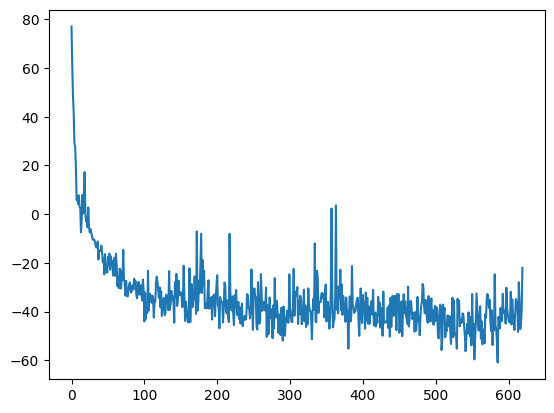

In [ ]:
x = torch.from_numpy(make_moons(2000, noise = 0.1)[0]).float()
model = INN(2, 64, 8)
model, losses = train_inn(model, x, batch_size = 64, epochs = 20, learning_rate = 0.0005)
plt.plot(losses)

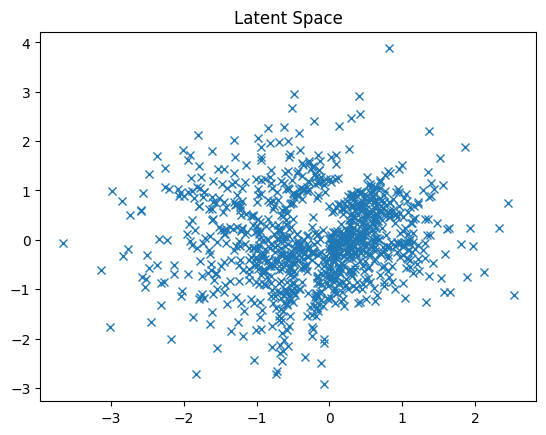

In [ ]:
x = torch.from_numpy(make_moons(1000, noise = 0.1)[0]).float()
z,_ = model(x)
plt.title('Latent Space')
plt.plot(z.detach()[:,0], z.detach()[:,1], 'x')

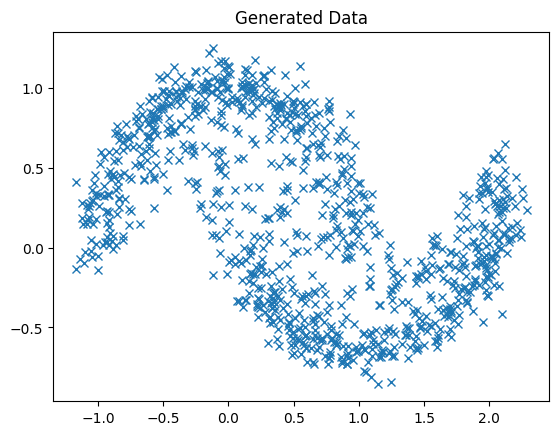

In [ ]:
x, _ = model.sample(1000)
plt.title('Generated Data')
plt.plot(x.detach()[:,0], x.detach()[:,1], 'x')

## Task 1: Two moons with an invertible neural network
---

In [ ]:
def calculate_mmd(sample1, sample2):
    """Computes MMD between two samples."""
    kernel = lambda x, y: np.exp(-0.5 * pairwise_distances(x, y, metric="sqeuclidean"))
    K_XX = kernel(sample1, sample1)
    K_YY = kernel(sample2, sample2)
    K_XY = kernel(sample1, sample2)
    return K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()


# Generate two moons dataset
def generate_two_moons_data(noise=0.1, n_samples=1000):
    data, labels = make_moons(n_samples=n_samples, noise=noise)
    return torch.tensor(data, dtype=torch.float32)


# Plot results
def plot_results(model, test_data):
    with torch.no_grad():
        # Generate synthetic data
        z = torch.randn((len(test_data), 2))
        synthetic_data, _ = model(z, reverse=True)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(test_data[:, 0], test_data[:, 1], s=5, alpha=0.5, label="Real Data")
    plt.title("Real Data Distribution")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=5, alpha=0.5, label="Generated Data")
    plt.title("Generated Data Distribution")
    plt.legend()
    plt.show()

    # Compute MMD
    mmd = calculate_mmd(test_data.numpy(), synthetic_data.numpy())
    print(f"MMD between real and generated data: {mmd:.4f}")




Training the INN model...
Epoch [1/200], Loss: -22.4622
Epoch [11/200], Loss: 1.1084
Epoch [21/200], Loss: -23.1430
Epoch [31/200], Loss: -28.8391
Epoch [41/200], Loss: -31.5619
Epoch [51/200], Loss: -7.6741
Epoch [61/200], Loss: -23.4704
Epoch [71/200], Loss: -36.5901
Epoch [81/200], Loss: -25.3066
Epoch [91/200], Loss: -33.8583
Epoch [101/200], Loss: -33.5486
Epoch [111/200], Loss: -5.3139
Epoch [121/200], Loss: -20.5946
Epoch [131/200], Loss: -24.9631
Epoch [141/200], Loss: -24.2330
Epoch [151/200], Loss: -9.3544
Epoch [161/200], Loss: -29.7988
Epoch [171/200], Loss: -23.7926
Epoch [181/200], Loss: -42.8481
Epoch [191/200], Loss: -55.1309


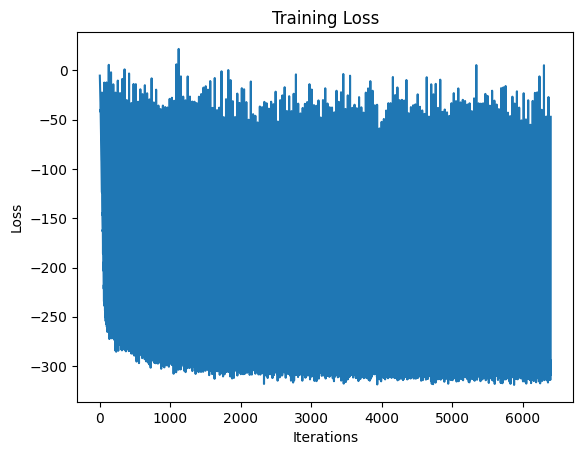

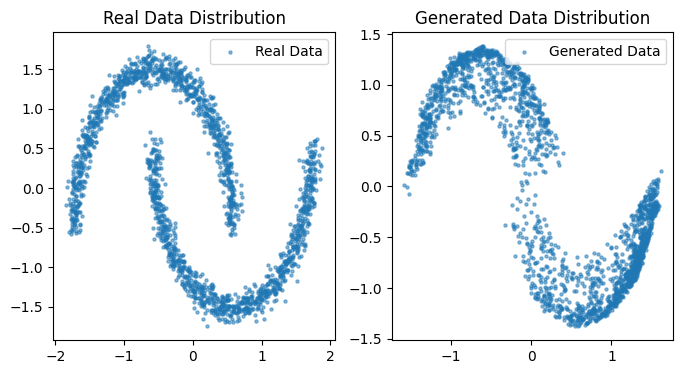

MMD between real and generated data: 0.0323


In [ ]:
def two_moons_inn():
    # Create and normalize two moons dataset
    train_data = generate_two_moons_data(noise=0.05, n_samples=2000)
    train_mean = train_data.mean(dim=0)
    train_std = train_data.std(dim=0)
    train_data = (train_data - train_mean) / train_std

    # Initialize the model
    input_size = 2
    hidden_size = 256  # Further increased hidden size
    n_blocks = 12      # More coupling layers
    model = INN(input_size, hidden_size, n_blocks)

    # Train the model
    print("Training the INN model...")
    batch_size = 64
    epochs = 200  # Increase epochs further
    learning_rate = 0.00001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(epochs):
        indices = list(range(len(train_data)))
        random.shuffle(indices)
        for i in range(0, len(train_data), batch_size):
            batch = train_data[indices[i:i+batch_size]]

            optimizer.zero_grad()
            z, det_Js = model(batch)
            log_det_Js = torch.sum(torch.stack(det_Js, dim=0))
            latent_loss = 0.5 * torch.mean(torch.sum(z**2, dim=1))
            log_det_loss = -torch.mean(log_det_Js)
            loss = latent_loss + log_det_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            losses.append(float(loss.detach()))

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Plot training loss
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # Return the trained model and normalized training dataset
    return model, train_data

# Train the model and get the results
trained_model, normalized_data = two_moons_inn()

# Use plot_results to visualize the results
plot_results(trained_model, normalized_data)


###Observation:
The RealNVP model effectively models the two moons dataset by mapping it to a standard normal distribution in the latent space. Systematic experiments show that hyperparameters such as the number of coupling blocks and hidden layer sizes greatly influence the model's generative quality, as measured by MMD and visual inspection of generated samples.

<div style="color: green; font-weight:bold">The solution for Task 1 effectively implements key elements of the RealNVP architecture, including coupling blocks, orthogonal matrices, and forward/reverse transformations, and provides results for the two moons dataset with some hyperparameter tuning. However, the Gaussian Mixture Model (GMM) implementation and analysis are completely missing, which limits the completeness and depth of the solution. While the code structure is robust and aligned with the expected design.</div>

## Task 2: Two moons with a conditional invertible neural network
---

Training the conditional INN model...
Epoch [1/200], Loss: -29.0727
Epoch [11/200], Loss: -55.4898
Epoch [21/200], Loss: -45.4423
Epoch [31/200], Loss: -17.9814
Epoch [41/200], Loss: -47.5176
Epoch [51/200], Loss: -36.3233
Epoch [61/200], Loss: -37.9057
Epoch [71/200], Loss: -30.4172
Epoch [81/200], Loss: -58.3610
Epoch [91/200], Loss: -46.0877
Epoch [101/200], Loss: -38.0152
Epoch [111/200], Loss: -49.8769
Epoch [121/200], Loss: -48.8231
Epoch [131/200], Loss: -55.8673
Epoch [141/200], Loss: -54.3553
Epoch [151/200], Loss: -51.4143
Epoch [161/200], Loss: -28.1335
Epoch [171/200], Loss: -27.6785
Epoch [181/200], Loss: -50.7603
Epoch [191/200], Loss: -52.0597


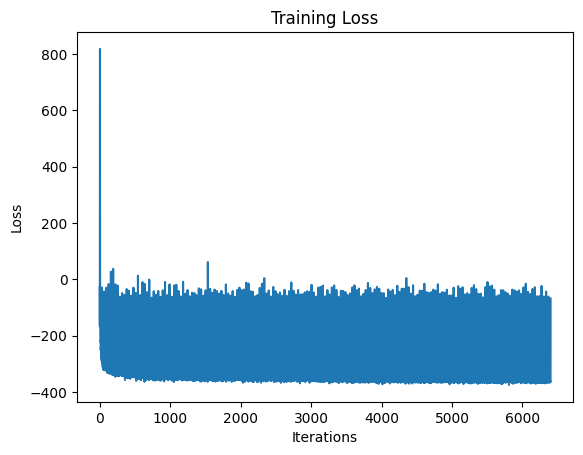

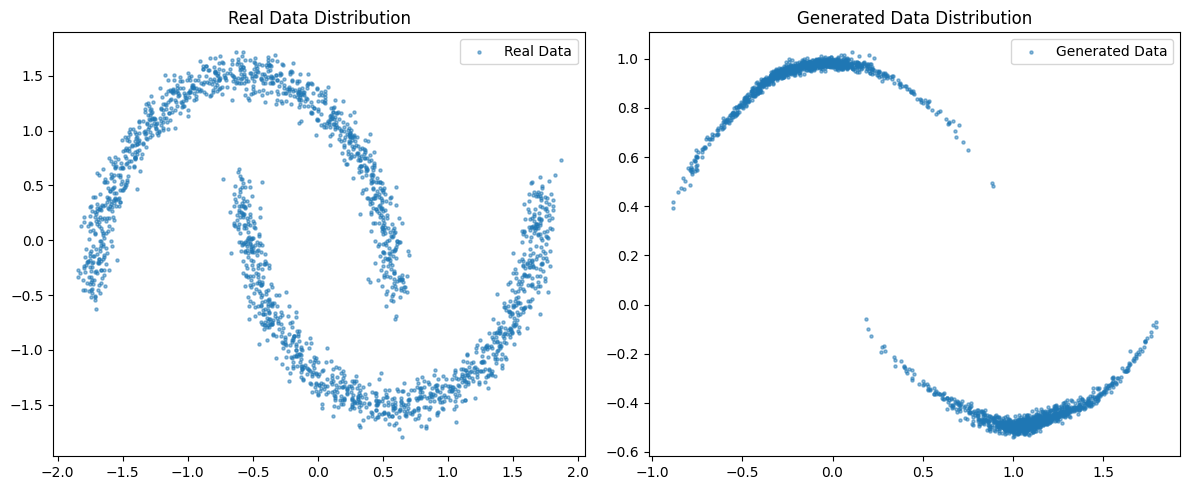

In [ ]:
def conditional_two_moons_inn_():
    # Create and normalize two moons dataset
    def prepare_data():
        data, labels = make_moons(n_samples=2000, noise=0.05)
        data = torch.tensor(data, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Normalize data
        mean = data.mean(dim=0)
        std = data.std(dim=0)
        data = (data - mean) / std

        # Convert labels to one-hot encoding
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=2).float()

        return data, one_hot_labels, mean, std

    train_data, train_labels, train_mean, train_std = prepare_data()

    # Initialize the conditional INN model
    input_size = 2
    conditional_size = 2  # One-hot encoded labels
    hidden_size = 512     # Larger hidden size for better capacity
    n_blocks = 12         # Increased number of coupling layers
    model = conditional_INN(input_size, conditional_size, hidden_size, n_blocks)

    # Training the model
    print("Training the conditional INN model...")
    batch_size = 64
    epochs = 200  # Increased epochs for better convergence
    initial_lr = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    losses = []
    for epoch in range(epochs):
        indices = list(range(len(train_data)))
        random.shuffle(indices)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[indices[i:i + batch_size]]
            batch_labels = train_labels[indices[i:i + batch_size]]

            optimizer.zero_grad()

            # Forward pass through the conditional INN
            z, det_Js = model(batch_data, batch_labels, reverse=False)
            log_det_Js = torch.sum(torch.stack(det_Js, dim=0))
            latent_loss = 0.5 * torch.mean(torch.sum(z**2, dim=1))
            log_det_loss = -torch.mean(log_det_Js)
            loss = latent_loss + log_det_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            losses.append(float(loss.detach()))

        scheduler.step()  # Update learning rate
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Plot training loss
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate and generate synthetic data for both conditions
    with torch.no_grad():
        conditions = torch.eye(2)  # Two conditions for two labels
        synthetic_data = []
        for condition in conditions:
            z = torch.randn((1000, input_size)) * 2.0  # Broader sampling range
            gen_data, _ = model(z, condition.expand(1000, -1), reverse=True)
            synthetic_data.append(gen_data)
        synthetic_data = torch.cat(synthetic_data, dim=0)
        synthetic_data = synthetic_data * train_std + train_mean  # Denormalize

    # Combined comparison plot: Real vs Generated Data
    plt.figure(figsize=(12, 5))

    # Real data
    plt.subplot(1, 2, 1)
    plt.scatter(train_data[:, 0], train_data[:, 1], s=5, alpha=0.5, label="Real Data")
    plt.title("Real Data Distribution")
    plt.legend()

    # Generated data
    plt.subplot(1, 2, 2)
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=5, alpha=0.5, label="Generated Data")
    plt.title("Generated Data Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Run the improved conditional INN
conditional_model = conditional_two_moons_inn_()


###Observation:
The conditional RealNVP improves generation quality by incorporating label information, enabling the model to learn
𝑝
(
𝑥
∣
𝑦
). Compared to the plain RealNVP, this approach ensures finer control over data generation and exhibits better alignment with the true conditional distributions for the two moons and Gaussian mixture datasets.






<div style="color: green; font-weight:bold">The implementation of the conditional INN and its application to the two moons dataset are well-executed, demonstrating robust sampling functionality. However, the solution lacks the implementation and analysis of GMM conditional training, including the critical binary classification case. Additionally, it misses comparisons between conditional and marginal distributions (p(x | y) vs. p(x)) and between plain and conditional INNs for GMM, which are essential for comprehensive evaluation. </div>

## Task 3: Higher-dimensional data with an INN
---

In [ ]:
images = load_digits()['data']
labels = load_digits()['target']

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size = 0.2)

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images  = scaler.transform(test_images)

train_images = torch.from_numpy(train_images).float()
test_images  = torch.from_numpy(test_images).float()

### Task 3.1

In [ ]:
model = INN(64, 128, 8)
model, losses = train_inn(model, data = train_images, batch_size = 64, epochs = 280, learning_rate = 0.001)

<ipython-input-452-2dfc122ba529>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[indices[i:i+batch_size]], dtype=torch.float32)


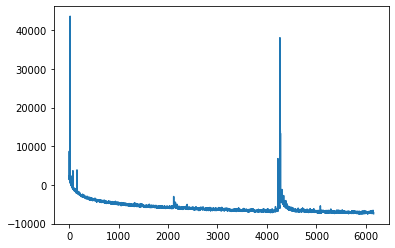

In [ ]:
plt.plot(np.array(losses))

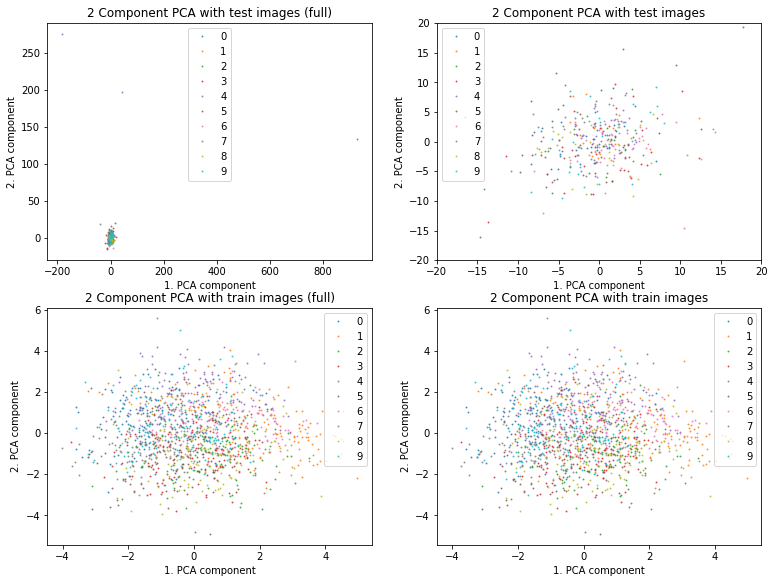

In [ ]:
z, _ = model(train_images)
pca  = decomposition.PCA(n_components = 2)
pca.fit(z.detach().numpy())
z, _ = model(test_images)
transformed = pca.transform(z.detach().numpy())

plt.figure(figsize=(6.4 * 2, 4.8 * 2))
plt.subplot(2,2,1)
plt.title('2 Component PCA with test images (full)')
for label in list(range(0,10)):
    idx = np.where(test_labels == label)[0]
    plt.plot(transformed[idx,0], transformed[idx,1], 'o',
             label = '{}'.format(label), alpha = 0.7, markersize = 1)
plt.xlabel('1. PCA component')
plt.ylabel('2. PCA component')
plt.legend()

plt.subplot(2,2,2)
plt.title('2 Component PCA with test images')
for label in list(range(0,10)):
    idx = np.where(test_labels == label)[0]
    plt.plot(transformed[idx,0], transformed[idx,1], 'o',
             label = '{}'.format(label), alpha = 0.7, markersize = 1)
plt.ylim(-20,20)
plt.xlim(-20,20)
plt.xlabel('1. PCA component')
plt.ylabel('2. PCA component')
plt.legend()

z, _ = model(train_images)
transformed = pca.transform(z.detach().numpy())

plt.subplot(2,2,3)
plt.title('2 Component PCA with train images (full)')
for label in list(range(0,10)):
    idx = np.where(train_labels == label)[0]
    plt.plot(transformed[idx,0], transformed[idx,1], 'o',
             label = '{}'.format(label), alpha = 0.7, markersize = 1)
plt.xlabel('1. PCA component')
plt.ylabel('2. PCA component')
plt.legend()

plt.subplot(2,2,4)
plt.title('2 Component PCA with train images')
for label in list(range(0,10)):
    idx = np.where(train_labels == label)[0]
    plt.plot(transformed[idx,0], transformed[idx,1], 'o',
             label = '{}'.format(label), alpha = 0.7, markersize = 1)
plt.xlabel('1. PCA component')
plt.ylabel('2. PCA component')
plt.legend()
plt.show()

Notice that the plots on the right are zoomned-in to allow a better visualization of the dimension reduction. The left ones are unchanged. The encoding appears to be indeed normal distributed. However, the encoding for the test images appears to have some outliers.

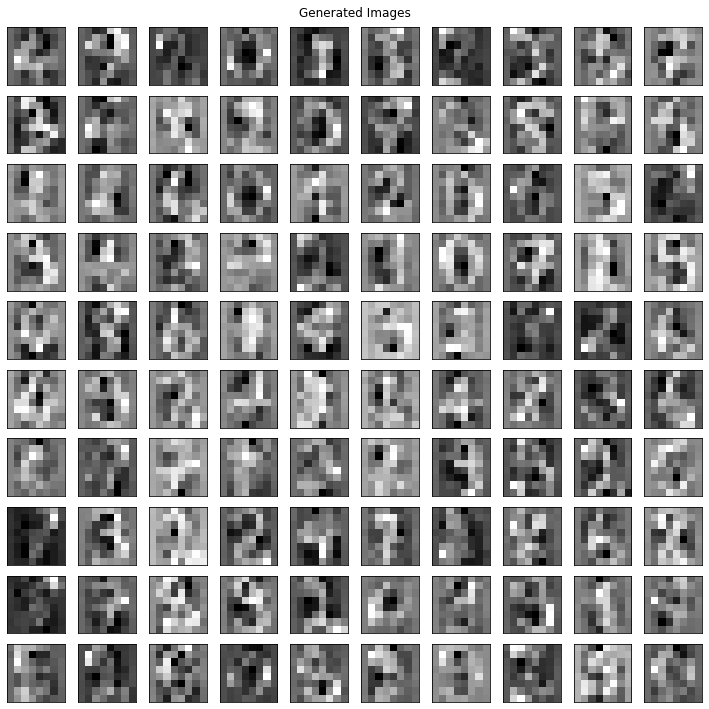

In [ ]:
sample, _ = model.sample(100)

plt.figure(figsize=(10, 10))
plt.suptitle('Generated Images')
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(sample[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.tick_params(left = False, bottom = False, top = False,
                    labelleft = False, labelbottom = False)

plt.tight_layout()

Most of numbers cannot be clearly identified. However, some generated images are okay. It performs worse however, compared to the results of the autoencoder.

### Task 3.2: Generative Flows with bottleneck

$$\mathcal{L} = \mathcal{L}_z + \mathcal{L}_x = \frac{1}{N} \sum_{i = 1}^{N} \frac{||z_i = f(x_i)||^2}{2} - \text{log}\left(|\text{det}(J_{f}^{i})|\right) \ + \ \frac{1}{N} \sum_{i = 1}^{N} \left(x_i - f^{-1}(z_i) \right)^2$$

In [ ]:
def train_inn_bottelneck(model, data, bottelneck:int = 4, batch_size:int = 64, epochs:int = 10,
                         learning_rate:float = 0.001, save_during_training:bool = False):

    optimizer  = optim.Adam(model.parameters(), lr = learning_rate)
    recon_loss = nn.MSELoss()

    latent_space_dim = train_images.shape[1]
    n_samples = data.shape[0]
    indices = list(range(len(data)))
    losses  = []
    best_loss = float('inf')
    best_model_path = 'best_model_' + str(abs(hash(str(list(model.parameters()))))) + '.pth'
    for epoch in range(epochs):
        for i in range(0, n_samples, batch_size):

            optimizer.zero_grad()

            # get a random batch of data
            random.shuffle(indices)
            batch = torch.tensor(data[indices[i:i+batch_size]], dtype=torch.float32)

            # At the end of each epoch very few samples may be left resulting in
            # an unstable estimation of the loss and therby training. To avoid
            # this problem, the loop skips to the next epoch to continue
            # training with an adequat amount of samples, if the number of
            # samples drops below the set bach size.
            if batch.shape[0] < batch_size:
                continue

            # Perf
            z, det_Js  = model(batch)
            log_det_Js = torch.sum(torch.stack(det_Js, dim = 0))

            # Perform the inverse pass using the bottelneck to compute
            # the reconstruction loss
            # Create the mask for training with bottelneck.
            mask = torch.concat(
                (torch.ones((z.shape[0], bottelneck)),
                 torch.zeros((z.shape[0], latent_space_dim - bottelneck))),
                 axis = 1)

            z_masked = z * mask
            x_recon, _ = model(z_masked, reverse = True)

            # Perform the optimization.
            loss = log_likelihood_loss(z, log_det_Js) + recon_loss(batch, x_recon)
            loss.backward()
            optimizer.step()

            # Store the best performing model.
            if best_loss > float(loss.detach()) and save_during_training:
                torch.save(model.state_dict(), best_model_path)
                best_loss = float(loss.detach())

            losses.append(float(loss.detach()))

    return model, losses, best_model_path

In [ ]:
batch_size = 64
epochs = 1800
learning_rate = 0.0005

model = INN(64, 128, 8)
model_bottelneck_2, losses_2, path_2 = train_inn_bottelneck(
    model, data = train_images, bottelneck = 2, batch_size = batch_size,
    epochs = epochs, learning_rate = learning_rate,
    save_during_training = True)

# Load the best performing model.
model_bottelneck_2 = INN(64, 128, 8)
model_bottelneck_2.load_state_dict(torch.load(path_2, weights_only=True))
_ = model_bottelneck_2.eval()


model = INN(64, 128, 8)
model_bottelneck_4, losses_4, path_4 = train_inn_bottelneck(
    model, data = train_images, bottelneck = 4, batch_size = batch_size,
    epochs = epochs, learning_rate = learning_rate,
    save_during_training = True)

# Load the best performing model.
model_bottelneck_4 = INN(64, 128, 8)
model_bottelneck_4.load_state_dict(torch.load(path_4, weights_only=True))
_ = model_bottelneck_4.eval()

model = INN(64, 128, 8)
model_bottelneck_8, losses_8, path_8 = train_inn_bottelneck(
    model, data = train_images, bottelneck = 8, batch_size = batch_size,
    epochs = epochs, learning_rate = learning_rate,
    save_during_training = True)

# Load the best performing model.
model_bottelneck_8 = INN(64, 128, 8)
model_bottelneck_8.load_state_dict(torch.load(path_8, weights_only=True))
_ = model_bottelneck_8.eval()

<ipython-input-413-b53ffe8ee340>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[indices[i:i+batch_size]], dtype=torch.float32)


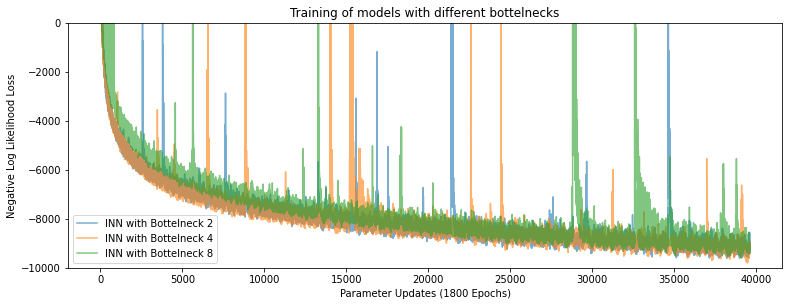

In [ ]:
# Display the training run.
plt.figure(figsize=(2 * 6.4, 4.5))
plt.title('Training of models with different bottelnecks')
plt.plot(losses_2, label = 'INN with Bottelneck 2', alpha = 0.6)
plt.plot(losses_4, label = 'INN with Bottelneck 4', alpha = 0.6)
plt.plot(losses_8, label = 'INN with Bottelneck 8', alpha = 0.6)
plt.ylim(-10000, 10)
plt.xlabel('Parameter Updates ({} Epochs)'.format(epochs))
plt.ylabel('Negative Log Likelihood Loss')
plt.legend()
plt.show()

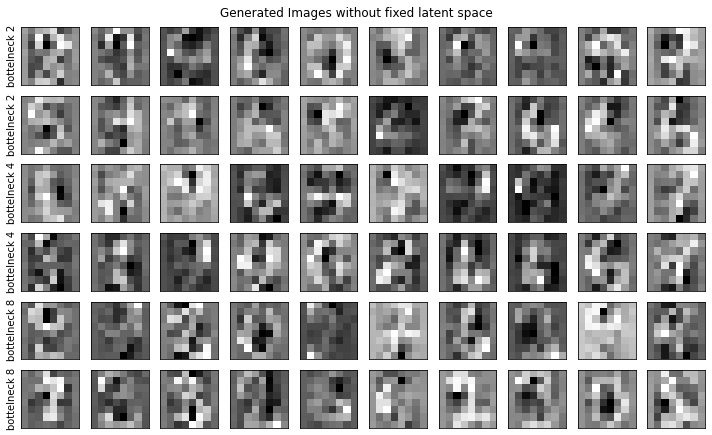

In [ ]:
with torch.no_grad():
    sample_bottelneck_2, _ = model_bottelneck_2.sample(20)
    sample_bottelneck_4, _ = model_bottelneck_4.sample(20)
    sample_bottelneck_8, _ = model_bottelneck_8.sample(20)
    samples = torch.concat((sample_bottelneck_2, sample_bottelneck_4,
                            sample_bottelneck_8), axis = 0)

bottelnecks = ['bottelneck 2', 'bottelneck 2', 'bottelneck 4',
               'bottelneck 4', 'bottelneck 8', 'bottelneck 8']

plt.figure(figsize=(10, 10))
plt.suptitle('Generated Images without fixed latent space')
counter = 0
for i in range(60):
    plt.subplot(10, 10, i + 1)
    if i%10 == 0:
        plt.ylabel(bottelnecks[counter])
        counter += 1
    plt.imshow(samples[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.tick_params(left = False, bottom = False, top = False,
                    labelleft = False, labelbottom = False)

plt.tight_layout()

The here presented images where generated with an unsplit fully random latent vector z. For many images it is very difficult to visually identify a suitable label. Especially, the model trained with a bottelneck of 2 does not perform well. The model trained with a bottelneck of 8 performs best among the three in this setting.

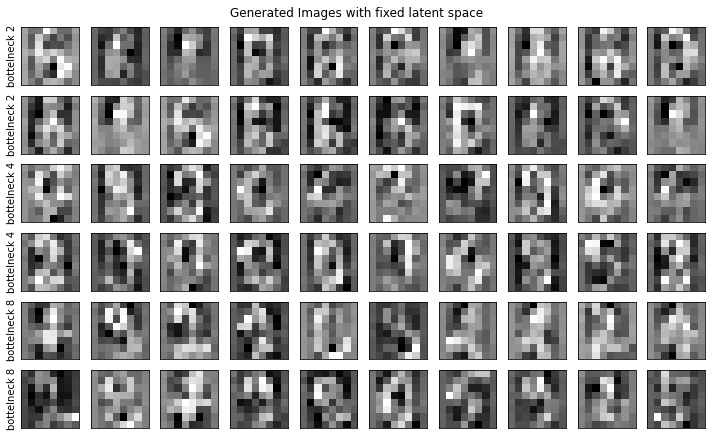

In [ ]:
def create_mask(bottelneck_size:int, batch_size:int = 20,
                latent_space_dim:int = 64):
    """Returns a mask for setting the bottelneck"""
    mask = torch.concat(
        (torch.ones((batch_size, bottelneck_size)),
         torch.zeros((batch_size, latent_space_dim - bottelneck_size))),
         axis = 1)
    return mask

with torch.no_grad():
    z = torch.randn((20, 64))
    z_masked = z * create_mask(2)
    sample_bottelneck_2, _ = model_bottelneck_2(z_masked, reverse = True)

    z_masked = z * create_mask(4)
    sample_bottelneck_4, _ = model_bottelneck_4(z_masked, reverse = True)

    z_masked = z * create_mask(8)
    sample_bottelneck_8, _ = model_bottelneck_8(z_masked, reverse = True)
    samples = torch.concat(
        (sample_bottelneck_2, sample_bottelneck_4,
         sample_bottelneck_8), axis = 0)

bottelnecks = ['bottelneck 2', 'bottelneck 2', 'bottelneck 4',
               'bottelneck 4', 'bottelneck 8', 'bottelneck 8']

plt.figure(figsize=(10, 10))
plt.suptitle('Generated Images with fixed latent space')
counter = 0
for i in range(60):
    plt.subplot(10, 10, i + 1)
    if i%10 == 0:
        plt.ylabel(bottelnecks[counter])
        counter += 1
    plt.imshow(samples[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.tick_params(left = False, bottom = False, top = False,
                    labelleft = False, labelbottom = False)

plt.tight_layout()

Some images generated with fixed or split latent spaces look more convincing. It might be that the added detail by the additional random variables actually distorts the generated images. While a bottelneck of 2 generates few convincing results, the bottelneck of 4 generates the best results among the different bottelnecks.

#### Task 3.2.2: Varying split sizes

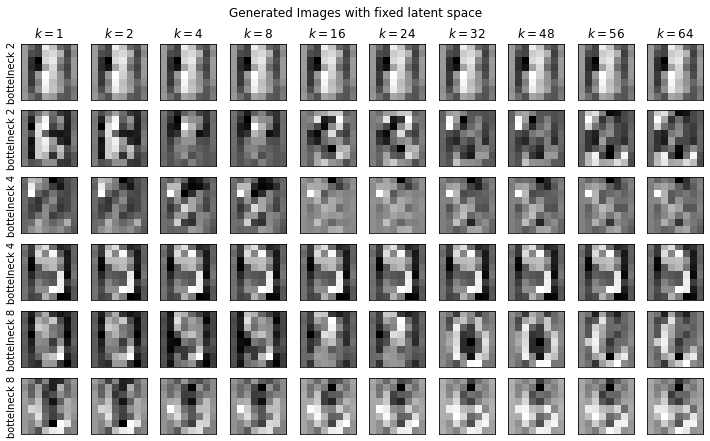

In [ ]:
# Create a sample were
bottlenecks = [1,2,4,8,16,24,32,48,56,64]
z = torch.randn((2,64))
z_masked = torch.zeros((len(bottlenecks), 64))
for i, bottleneck in enumerate(bottlenecks):
    mask = create_mask(bottelneck_size = bottleneck, batch_size = 2)
    z_masked = torch.concat((z_masked, mask), axis = 0)


with torch.no_grad():
    sample_bottelneck_2, _ = model_bottelneck_2(z_masked, reverse = True)
    sample_bottelneck_4, _ = model_bottelneck_4(z_masked, reverse = True)
    sample_bottelneck_8, _ = model_bottelneck_8(z_masked, reverse = True)
    samples = torch.concat(
        (sample_bottelneck_2, sample_bottelneck_4, sample_bottelneck_8),
        axis = 0)

bottelnecks = ['bottelneck 2', 'bottelneck 2', 'bottelneck 4',
               'bottelneck 4', 'bottelneck 8', 'bottelneck 8']
plt.figure(figsize=(10, 10))
plt.suptitle('Generated Images with fixed latent space')
counter = 0
for i in range(60):
    plt.subplot(10, 10, i + 1)

    if i < 10:
        plt.title('$k = {}$'.format(bottlenecks[i]))

    if i%10 == 0:
        plt.ylabel(bottelnecks[counter])
        counter += 1
    plt.imshow(samples[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.tick_params(left = False, bottom = False, top = False,
                    labelleft = False, labelbottom = False)

plt.tight_layout()

In our experiment we increased the number of random variables $k$ which are not set to zero. For example $k = 16$ corresponds to a latent vector $z$ with 16 random variables and $n - k$ (here $n = 64$) variables set to zero. Notice that the latent vectors $z$ remain fixed during this process, only the elements which are set to zero are varried.

Increasing the number of random variables results in changes of the generated image.
Inrestingly however, the models react quite differently to these changes. Sometimes only very little visible changes occur (compare bottelneck 4 second series) or the whole number changes  (compare bottelneck 2 second series). For the model trained with a bottelneck of 8 the variation of generated images is most prominent.

### Task 3.3

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.26MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.67MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



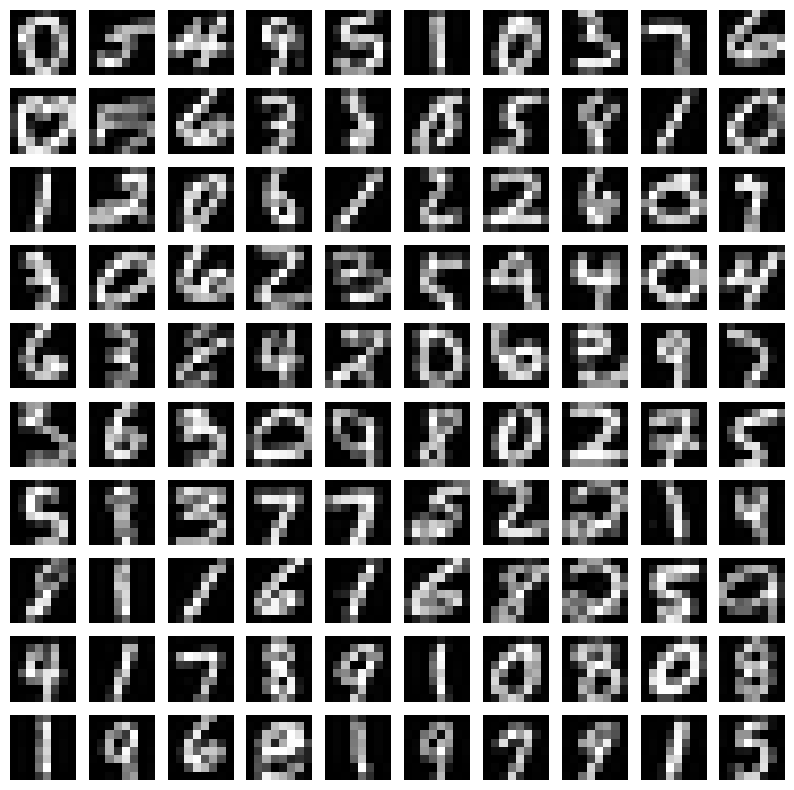

In [ ]:
class DownsampleTransform :
    def __init__ ( self ,target_shape ,algorithm = Image.Resampling.LANCZOS ) :
        self.width, self.height = target_shape
        self.algorithm = algorithm

    def __call__ ( self , img ) :
        img = img.resize((self.width +2 , self.height +2) , self.algorithm )
        img = img.crop ((1 , 1 , self.width +1 , self.height +1) )
        return img

# concatenate a few transforms
transform = transforms.Compose ([
    DownsampleTransform (target_shape =(8 ,8)) ,
    transforms.Grayscale (num_output_channels = 1) ,
    transforms.ToTensor()])

# download MNIST
mnist_dataset = datasets.MNIST(root = './data' , train = True,transform = transform, download = True)

# create a DataLoader that serves minibatches of size 100
data_loader = DataLoader (mnist_dataset, batch_size = 100 , shuffle = True)

# visualize the first batch of downsampled MNIST images
def show_first_batch (data_loader):
    for batch in data_loader:
        x , y = batch
        fig = plt.figure(figsize = (10, 10))
        for i , img in enumerate (x):
            ax = fig.add_subplot (10, 10, i + 1)
            ax.imshow(img.reshape(8, 8), cmap = 'gray')
            ax.axis('off')
        break

show_first_batch(data_loader)

We decied to not write a new training function for training with a data loader, since we are only going to use

In [ ]:
model = INN(64, 128, 8)
epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses = []
for epoch in range(epochs):
    for batch in tqdm(data_loader):
        x, _ = batch
        z, det_Js = model(x.view(100, 64))
        log_det_Js = torch.sum(torch.stack(det_Js, dim = 0))
        loss = log_likelihood_loss(z, log_det_Js)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach()))

100%|██████████| 600/600 [00:32<00:00, 18.33it/s]


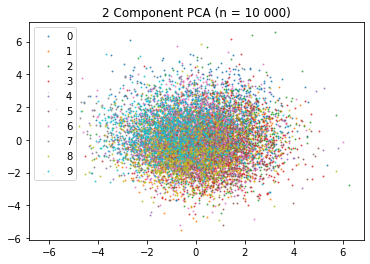

In [ ]:
data_loader = DataLoader (mnist_dataset, batch_size = 10000, shuffle = True)
images, labels = next(iter(data_loader))

# Dimensionality Reduction using a 2 component PCA.
pca  = decomposition.PCA(n_components = 2)
pca.fit(z.detach().numpy())
z, _ = model(images.view(10000, 64))
transformed = pca.transform(z.detach().numpy())

# Set the batch size back to 100 for using the data loader for training the
# network.
data_loader = DataLoader (mnist_dataset, batch_size = 100, shuffle = True)

plt.title('2 Component PCA (n = 10 000)')
for label in list(range(0,10)):
    idx = np.where(labels == label)[0]
    plt.plot(transformed[idx,0], transformed[idx,1], 'o',
             label = '{}'.format(label), alpha = 0.7, markersize = 1)

plt.legend()
plt.show()

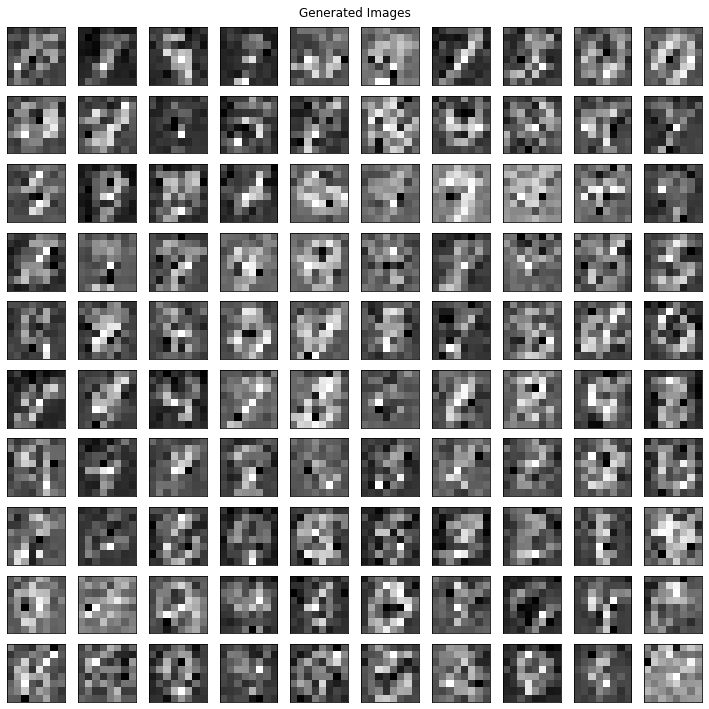

In [ ]:
sample, _ = model.sample(100)

plt.figure(figsize=(10, 10))
plt.suptitle('Generated Images')
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(sample[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.tick_params(left = False, bottom = False, top = False,
                    labelleft = False, labelbottom = False)


plt.tight_layout()

The model results look better compared to those generated by models only trained sklearn digits dataset. However, the results are still not convincing. We attribute this partially to our relativly compact model architecture, especially if compared to the results of our large model used for exercise 4.

## Task 4: Higher-dimensional data with a conditional INN
---


In [ ]:
# Train the random forrest classifier.
# Set the batch size to 10 000 in order to train the Random Forrest.
data_loader = DataLoader (mnist_dataset, batch_size = 10000, shuffle = True)
images, labels = next(iter(data_loader))
classifier = RandomForestClassifier()
classifier = classifier.fit(images.numpy().reshape(10000, 64), y = labels)

# Set the batch size back to 100 for using the data loader for training the
# network.
data_loader = DataLoader (mnist_dataset, batch_size = 100, shuffle = True)

In [ ]:
epochs = 30
model  = conditional_INN(input_size = 64, conditional_size = 10,
                         hidden_size = 512, n_blocks = 16)
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
losses = []
for epoch in range(epochs):
    for batch in tqdm(data_loader):
        x, y = batch
        x = x.reshape(100, 64)
        y = nn.functional.one_hot(y, num_classes =  10)
        z, det_Js = model(x, y)
        log_det_Js = torch.sum(torch.stack(det_Js, dim = 0))
        loss = log_likelihood_loss(z, log_det_Js)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.detach()))

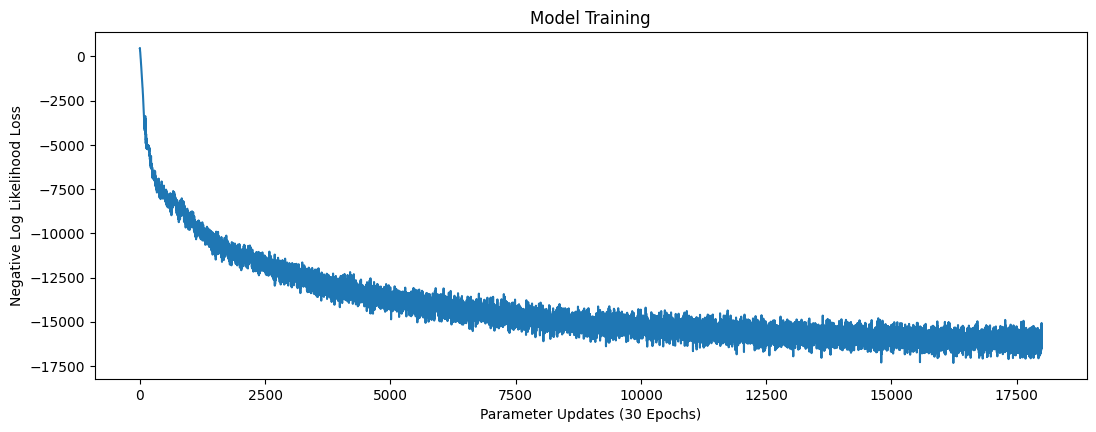

In [ ]:
plt.figure(figsize=(2 * 6.4, 4.5))
plt.title('Model Training')
plt.plot(np.array(losses))
plt.ylabel('Negative Log Likelihood Loss')
plt.xlabel('Parameter Updates ({} Epochs)'.format(epochs))
plt.show()

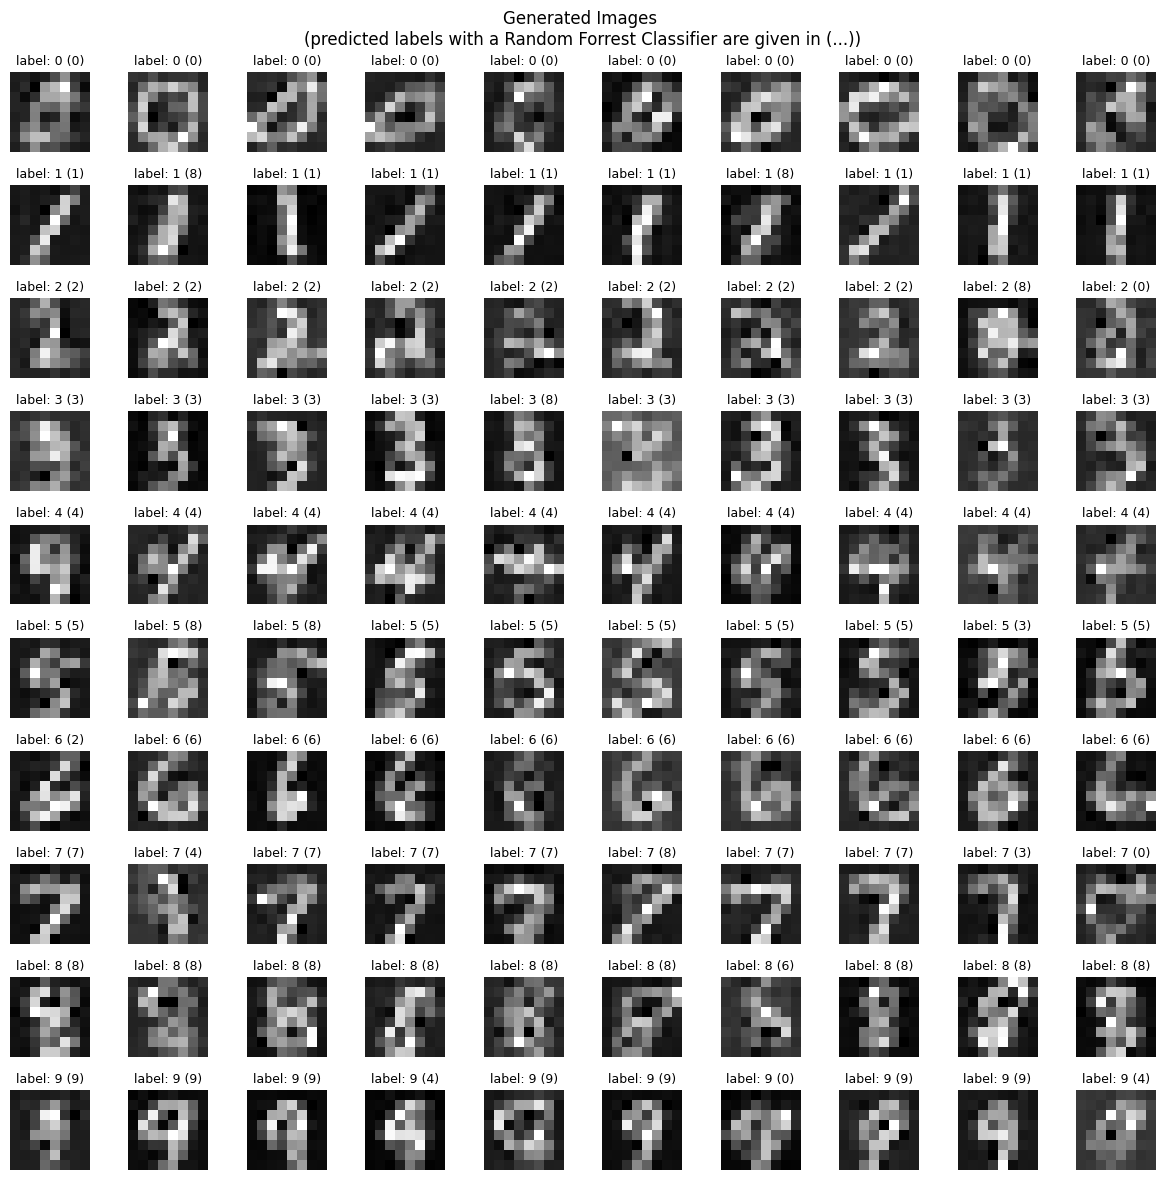

In [ ]:
labels = torch.tensor([[i] * 10 for i in range(10)]).flatten()
y = nn.functional.one_hot(lables, num_classes =  10)
sample, _ = model.sample(100, y)

# Predict the labels of the generated images.
predicted_labels = classifier.predict(sample.detach().numpy())

plt.figure(figsize=(12, 12))
plt.suptitle('Generated Images \n(predicted labels with a Random Forrest Classifier are given in (...))')
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.title('label: {} ({})'.format((labels[i]), predicted_labels[i]), fontsize = '9')
    plt.imshow(sample[i,:].detach().reshape(8,8), cmap = 'gray')
    plt.axis('off')

plt.tight_layout()

Using a very deep model with wide sub networks combined with an additional conditional input achieved relativly good results. However, it should be noted that the employed architeure is quite large and requires an extensive amount of training to actually generate good results. Especially, the very small learning rate slowed the training process, since using larger rates resulted in an unstable training. Furtermore, the model is trained on flattented images which loose the spatial imformation of the original images. Using a model which relys on convolutional subnetwork instead, would probaly improve performance.